# Задача

Задача 2 двухмерная модель Изинга на странице 8 в ["Python. Список задач 5. Модель Изинга, алгоритм Метрополиса"](http://theor.mephi.ru/wiki/images/b/b8/Python_problem_set_5.pdf).

Двухмерная модель Изинга:

$$x_{i, \ j} = \pm 1$$

$$h = B g \mu_b$$

$$E(x) = - J \sum_{i, \ j} \left(x_{i + 1, \ j} + x_{i, \ j + 1}\right) x_{i, \ j} - h \sum_{i, \ j} x_{i, \ j}$$

$$M(x) = \frac 1 N \sum_{i, \ j} x_{i, \ j}$$

# Решение

In [1]:
from numpy import *
import matplotlib.pyplot as plt
import numba as nb
# %load_ext line_profiler
%matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

@nb.njit
def seed(x):
    random.seed(x)

Символьно предвычисленные выражения для ускорения шага алгоритма Метрополиса:

$$\Delta E_{i, \ j} = 2 J \left( x_{i - 1, \ j} + x_{i, \ j - 1} + x_{i + 1, \ j} + x_{i, \ j + 1} \right) x_{i, \ j} + 2 h x_{i, \ j}$$

$$\Delta M_{i, \ j} = - 2 \frac 1 N x_{i, \ j}$$

Производительная программа `calc_model_nb` для расчета двухмерной модели Изинга алгоритмом Метрополиса:

In [2]:
%%time
@nb.njit('(int64[:, ::1], float64[::1], int64, int64, int64, int64)', parallel=True)
def calc_model_nb(x, T_level, n_step, window, J, h):
    k_Boltzmann = 1

    n_side = x.shape[0] - 2
    n_particles = n_side * n_side
    n_level = T_level.shape[0]
    
    E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
    M0 = x.sum() / n_particles

    E_level = empty(n_level)
    C_level = empty(n_level)
    M_level = empty(n_level)
    E = empty(n_step)
    M = empty(n_step)
    E[-1] = E0
    M[-1] = M0

    for l in range(n_level):
        T = T_level[l]

        for k in range(n_step):
            i = random.randint(1, n_side + 1)
            j = random.randint(1, n_side + 1)

            dE = 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j]
            dM = - 2 * x[i, j] / n_particles

            if dE <= 0:
                x[i, j] = - x[i, j]
            else:
                R = exp(- dE / k_Boltzmann / T)
                r = random.rand()

                if r <= R:
                    x[i, j] = - x[i, j]
                else:
                    dE = 0
                    dM = 0

            E[k] = E[k - 1] + dE
            M[k] = M[k - 1] + dM

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM

    return E_level, C_level, M_level

CPU times: user 5 s, sys: 30 ms, total: 5.03 s
Wall time: 5.09 s


Установка состояния генератора случайных чисел для воспроизводимости результата в ноутбуке

In [3]:
seed(0)

Двухмерный массив $x$ имеет размер $(n + 2, n + 2)$, где $n$ -- сторона квадрата системы частиц со спином $-1$ или $1$.

Значения на границе массива равны нулю. Внутри массива могут быть значения $-1$ или $1$, обозначающие состояния частиц.

Начальное состояние всех частиц 1. Все частицы сонаправлены ("холодный" старт симуляции модели).

Длина стороны квадрата системы: $n = 400$.

Число частиц: $n \cdot n = 160000$.

Энергия взаимодействия: $J = 1$.

Магнитное поле выключено: $B = 0$.

In [4]:
n_side = 400  # длина стороны квадрата системы
J = 1  # энергия взаимодействия
B = 0  # магнитное поле выключено
g = 1
mu_b = 1
h = B * g * mu_b
n_particles = n_side * n_side  # число частиц

# создание массива x
n = n_side
# random.seed(0)  # для воспроизводимости результата
# x = random.randint(2, size=(n + 2, n + 2)) * 2 - 1  # "горячий" старт
x = full((n + 2, n + 2), 1)  # "холодный" старт

# задание границы массива x со значениями нули
x[0, :] = x[:, 0] = x[n + 1, :] = x[:, n + 1] = 0

Вызов `calc_model_nb` для расчета двухмерной модели Изинга алгоритмом Метрополиса:

In [5]:
# число уровней температуры
n_level = 200
# число шагов алгоритма Метрополиса для одного уровня температуры
# n_step = 1000000
n_step = 10 * n_particles
# ширина окна выборки случайных величин E, C, M для одного уровня температуры
window = round(5 / 6 * n_step)
# уровни температуры в отрезке (0, 5] (ноль исключен)
T = linspace(0, 5, n_level + 1)[1:]
E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 47.3 s, sys: 54 ms, total: 47.3 s
Wall time: 33.2 s


Построение графиков энергии $E$, темплоемкости $C$, намагниченности $M$ от температуры $T$:

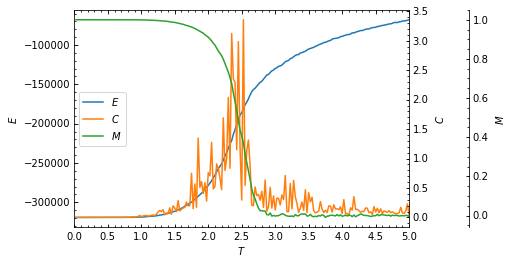

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

Темплоемкость расходится в точке Кюри $T = T_c \approx 2.269185 J$. На графике темплоемкости $C(T)$ приблизительно в $T_c$ наблюдается резкий пик.

Повышение погрешности в окрестности точки Кюри является проблемой критического замедления. Метод параллельного отжига служит решением данной проблемы.  Информация по проблеме критического замедления и методу параллельного отжига есть в материале [Методы канонического и мультиканонического семплирования пространства состояний векторных моделей](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=dvmg&paperid=346&option_lang=rus).

Все потоки процессора не были загружены полностью в процессе расчета модели. Только один поток был полностью загружен. Для полноценной загрузки всех потоков планируется заменить схему решения на ту схему, которая пригодна для распараллеливания на потоки процессора, и распараллелить схему решения с помощью библиотеки Numba на Python. Предположительно, пригодная для данного распараллеливания схема есть по ссылке [Red/Black or Checkerboard Update](http://www.new-npac.org/projects/cdroms/cewes-1999-06-vol1/cps615course/csematerials/applications/mc/montecarlo/node64.html).

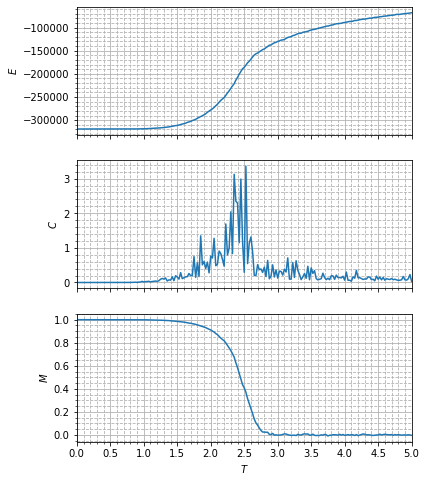

In [7]:
a, b = 1, 2
fig, (axE, axC, axM) = plt.subplots(3, 1, sharex=True, figsize=(a * 6, b * 4))
axM.set_xlabel('$T$')  # Температура
axE.set_ylabel('$E$')  # Энергия
axC.set_ylabel('$C$')  # Темплоемкость
axM.set_ylabel('$M$')  # Намагниченность
axE.plot(T, E)
axC.plot(T, C)
axM.plot(T, M)
axM.set_xlim(0, 5)

for ax in axE, axC, axM:
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
axM.xaxis.set_major_locator(MultipleLocator(0.5))
axM.xaxis.set_minor_locator(AutoMinorLocator())
for ax in axM, axE, axC:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.show()

In [8]:
seed(1)

# ----------
n_side = 40
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side

# ----------
n = n_side
# x = random.randint(2, size=(n + 2, n + 2)) * 2 - 1  # hot
x = full((n + 2, n + 2), 1)  # cold
x[0, :] = 0
x[:, 0] = 0
x[n + 1, :] = 0
x[:, n + 1] = 0

# ----------
n_level = 50
n_step = 10 * n_particles
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 246 ms


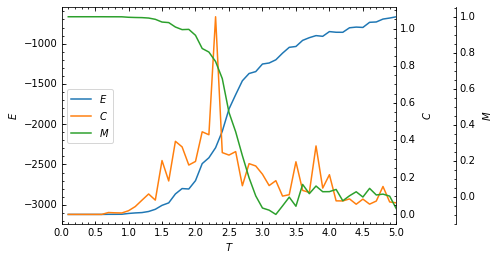

In [9]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in host, par1, par2:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

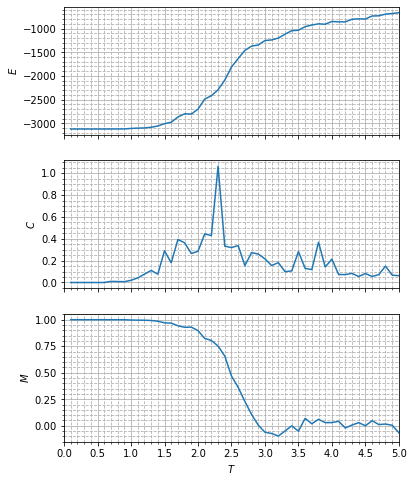

In [10]:
a, b = 1, 2
fig, (axE, axC, axM) = plt.subplots(3, 1, sharex=True, figsize=(a * 6, b * 4))
axM.set_xlabel('$T$')  # Температура
axE.set_ylabel('$E$')  # Энергия
axC.set_ylabel('$C$')  # Темплоемкость
axM.set_ylabel('$M$')  # Намагниченность
axE.plot(T, E)
axC.plot(T, C)
axM.plot(T, M)
axM.set_xlim(0, 5)

for ax in axE, axC, axM:
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
axM.xaxis.set_major_locator(MultipleLocator(0.5))
axM.xaxis.set_minor_locator(AutoMinorLocator())
for ax in axM, axE, axC:
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.show()